In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gseapy as gp
import pickle
from tqdm import tqdm
plt.style.use('default')

In [111]:
# 定义目录和样本列表
inputdir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423' # expression matrix & sample information
networkdir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423/data' # ae networks
outdir = '/mnt/disk7t/xwj/axolotl_rev/pfib_423/output' # output directory: figures,  tables

# table of expression outlier analysis
result_baseline = {
    'outsingle':f'{inputdir}/osg_res_1_001.txt', # method 1
    'outrider': f'{inputdir}/outrider_res_1_001.txt', # method 2
    'outrider_cts': f'{inputdir}/outrider_norm_cts_1_001.txt',
    'trueoutlier': f'{inputdir}/df_true49.txt', # known outlier information
}

# file = f'{datadir}/df_true49.txt'
df_outlier = pd.read_csv(result_baseline['trueoutlier'], sep="\t", index_col=None)
list_samples = df_outlier['Sample'].tolist()

# names of samples to be highlighted in clustermap 
hi_samples = ['R15264','R52016','R28774']
print(len( hi_samples), len(list_samples), df_outlier.shape)

# 定义通用的文件路径模板
file_node_df_template = "{networkdir}/node_df_{sample}.txt"
file_heatmap_template = "{outdir}/gsea_heatmap_{method}.pdf"
# 输出文件
file_gene_set = f'{outdir}/gmt.pkl'
file_hi_gsea_result = f'{outdir}/gsea_results.txt'
file_go_box = f"{outdir}/go_box.svg"

3 49 (49, 5)


In [2]:
# 初始化 Msigdb API
msig = gp.Msigdb()
print(len( msig.list_category() ))

32


In [82]:
# 下载特定的基因集文件
# 'h.all'
catg = 'c5.go.bp'
dv = '2024.1.Hs'
gmt = msig.get_gmt(category=catg, dbver=dv)
len( gmt )

7608

In [80]:
with open(file_gene_set, 'wb') as f:
    pickle.dump(gmt, f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 357.65it/s]


(10840, 7) (49, 5) 49


,id,AE,group,5,10,15,sample
0,ALDH18A1,8.186405e-16,AE,0,0,0,R80184
1,TMEM263,7.829135e-01,L1,0,0,0,R80184
2,MAGED1,9.435964e-03,L1,0,0,0,R80184
3,SEC31A,3.416909e-01,L1,0,0,0,R80184
4,BET1L,6.100061e-01,L1,0,0,0,R80184


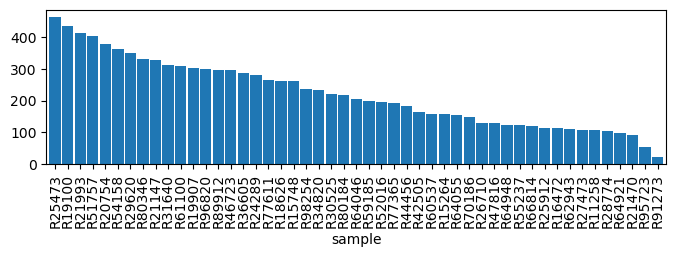

In [125]:
# Loop through the sample list and read node list file, then concatenate
dfs = []
for sample in tqdm(list_samples):
    # file_path = f'{networkdir}/data/node_df_{sample}.txt'
    file_path = file_node_df_template.format(networkdir=networkdir, sample=sample)
    temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
    temp_df['sample'] = sample  # Add a column to identify the sample
    # print(temp_df.shape)
    dfs.append(temp_df)

# Concatenate all dataframes
df = pd.concat(dfs)
print( df.shape, df_outlier.shape, len(dfs) )
df['sample'].value_counts(sort=True).plot(kind='bar', width=0.9, figsize =(8,2))
df.head()

In [ ]:
# 输入df,按照sample名称分组，提取3个genelist; 用每个 genelist 运行 GSEA 分析，结果合并成一个 dataframe，绘制热图
gene_lists = {sample: df.query('sample == @sample')['id'].tolist() for sample in hi_samples}

In [109]:
len(enrich_dict['node_of_net'])
# 运行 GSEA 分析并合

49

In [123]:
gene_lists = {sample: df.query('sample == @sample')['id'].tolist() for sample in list_samples}
enrich_dict = {}
# 运行 GSEA 分析并合并结果
enrich_results = []
for sample, genes in tqdm(gene_lists.items()):
    enrichment_gsea = gp.enrichr(gene_list=genes, gene_sets=gmt, outdir=None)
    enrichment_gsea.res2d['sample'] = sample
    enrich_results.append(enrichment_gsea.res2d)

enrich_dict['node_of_net'] = enrich_results

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:56<00:00,  3.60s/it]


In [124]:
# 以此基因数量为准，对score按照每列进行从小到大排序,这里涉及多种方法

# your_dataset_file = '/media/eys/xwj/axolotl_rev/pfib_423/df_cts_gm2022_dedup.txt'

#------------------------------------------------------------------------#
gene_lists_by_score = {}
'''上游异常表达基因的算法结果，有多种'''
for method in [ 'outsingle', 'outrider' ]:
    file = result_baseline[method]
    print(f"Processing {method}...: {file}")
    score = pd.read_csv(file, sep="\t", index_col=0)
    if method == 'outrider':
       score = score.pivot(index='geneID', columns='sampleID', values='pValue')

    sorted_score = score.apply(lambda x: x.sort_values().index, axis=0)

    # 针对每个样本从score中取出gene_list字典中此样本的相同数量的基因
    gene_lists_by_score[method] = {}
    for sample, genes in tqdm( gene_lists.items()):
        gene_lists_by_score[method][sample] = sorted_score[sample][:len(genes)].tolist()
    if False:
        # 确认一下每个样本从选出的基因数量是否正确
        for sample, genes in gene_lists_by_score[method].items():
            print(f"{sample}: take {len(genes)}, need {len(gene_lists[sample])}")

    # 进行GSEA分析
    enrich_results = []
    for sample, genes in tqdm( gene_lists_by_score[method].items()):
        enrichment_gsea = gp.enrichr(gene_list=genes, gene_sets=gmt, outdir=None)
        enrichment_gsea.res2d['sample'] = sample
        enrich_results.append(enrichment_gsea.res2d)
        
    enrich_dict[ method ] = enrich_results

Processing outsingle...: /mnt/disk7t/xwj/axolotl_rev/pfib_423/osg_res_1_001.txt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:51<00:00,  3.50s/it]


In [126]:
# 合并所有结果
filtered_results = []

for key in enrich_dict:
    enrich_results = enrich_dict[key]
    df_enrich = pd.concat(enrich_results)
    
    pivot_df = df_enrich.pivot(index='Term', columns='sample', values='Adjusted P-value')
    pivot_df = pivot_df.fillna(1)
    
    # 阈值0.05进行过滤
    # df_enrich = df_enrich[df_enrich['Adjusted P-value'] < 0.1]
    # pivot_df = pivot_df.transform(lambda x: -np.log10(x)).astype(np.float32)
    # pivot_df = pivot_df.replace(-0.0, 0.0)
    
    print(key, pivot_df.shape, )
    filtered_results.append(pivot_df)

# 将所有过滤后的结果保存到一个 dataframe 里
final_df = pd.concat(filtered_results, keys=enrich_dict.keys())

final_df = final_df[(final_df < 0.1).any(axis=1)] 

node_of_net (6921, 49)
outsingle (7307, 49)
outrider (7339, 49)


/tmp/ipykernel_150183/2485214638.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


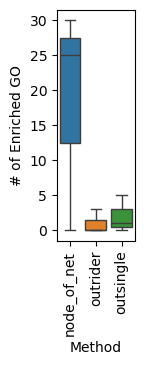

In [ ]:
draw = (final_df < 0.05).groupby(level=[0]).sum().T
fig, ax = plt.subplots(figsize=(1, 3))
# 绘制箱线图
sns.boxplot(draw,fill=True, width=0.8, ax=ax)
ax.set_xlabel('Method')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('# of Enriched GO')
# 保存为 SVG 文件
plt.savefig(file_go_box, bbox_inches="tight") 

In [87]:
# [final_df.index.levels[0], final_df.index.levels[1].map(lambda x: x.title() if x.startswith('GOBP_') else x)]
final_df.index = final_df.index.set_levels([final_df.index.levels[0], final_df.index.levels[1].map(lambda x: x.title() if x.startswith('GOBP_') else x)], level=[0,1])
final_df.round(3).to_csv(file_hi_gsea_result, sep='\t')

In [88]:
final_df.head()

sample                                   R15264    R28774    R52016
            Term                                                   
node_of_net Gobp_Aerobic_Respiration   0.035789  0.303761  0.231197
            Gobp_Apoptotic_Process     0.075128  0.728178  0.574174
            Gobp_Cellular_Respiration  0.070547  0.216029  0.182512
            Gobp_Cell_Cycle            0.012711  0.597728  0.540260
            Gobp_Cell_Cycle_Process    0.012711  0.434141  0.662311

In [90]:
! ls -lhrt {outdir}

total 5.4M
-rw-rw-r--  1 xwj xwj  24K May 15 08:47 go_box.svg
-rw-rw-r--  1 xwj xwj  29K May 15 08:47 gsea_heatmap_node_of_net.pdf
-rw-rw-r--  1 xwj xwj  19K May 15 08:47 gsea_heatmap_outsingle.pdf
-rw-rw-r--  1 xwj xwj  17K May 15 08:47 gsea_heatmap_outrider.pdf
-rw-rw-r--  1 xwj xwj 5.3M May 15 16:34 gmt.pkl
-rw-rw-r--. 1 xwj xwj 5.7K May 15 16:42 gsea_results.txt


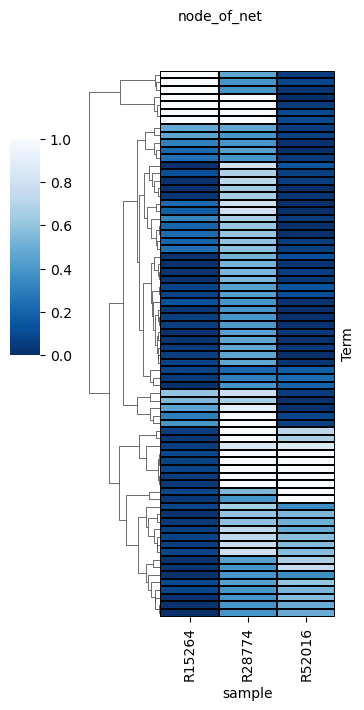

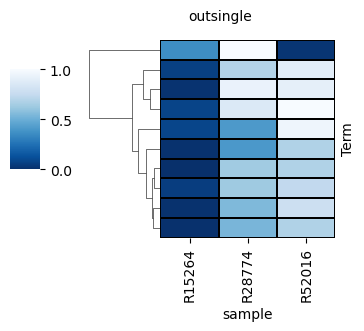

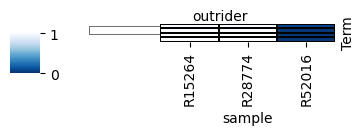

In [99]:

# 绘制热图
#  figsize=(3,5),
methods = final_df.index.levels[0]
for method in methods:
    method_df = final_df.loc[method]
    fig_width, fig_height = 3, method_df.shape[0]/15
    if fig_height < 3:
        fig_height = 3
    if len(hi_samples) < 4:
        if method == 'node_of_net':
            fig_height = method_df.shape[0]/10
        else:
            fig_height = method_df.shape[0]/3
    else:
        fig_width = method_df.shape[0]/5
        fig_height = method_df.shape[0]/20
    g = sns.clustermap(method_df, cmap='Blues_r', col_cluster=False, row_cluster=True, z_score=None,
                       linewidths=0.1, linecolor='black', vmin = 0,
                        # dendrogram_ratio=(0.5,0.1), colors_ratio=0.05, cbar_pos=(0, 0.5, 0.05,0.3, ), cbar_kws={'ticks':[-2, -1,0,1, 2, 3]},  
                        cbar_pos=(-0.2, 0.5, 0.1, 0.3),  dendrogram_ratio=(0.3,0.1), yticklabels=False, figsize=(fig_width, fig_height))
    # g.ax_heatmap.set_title(f'Heatmap for {method}')
    #                   ) # standard_scale=1,
    g.fig.suptitle(f'{method}',fontsize=10) 
    # plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=3)  
    # plt.tight_layout()
    plt.savefig(file_heatmap_template.format(outdir=outdir, method=method), bbox_inches='tight')
    # # Adjust the fontsize for y-axis labels

In [100]:
method_df

sample,R15264,R28774,R52016
Term,,,
Gobp_Nls_Bearing_Protein_Import_Into_Nucleus,1.0,1.0,0.031004
Gobp_Peptidyl_Lysine_Methylation,1.0,1.0,0.031004
Gobp_Regulation_Of_Protein_Exit_From_Endoplasmic_Reticulum,1.0,1.0,0.031004
Gobp_Regulation_Of_Retrograde_Protein_Transport_Er_To_Cytosol,1.0,1.0,0.063748
